# Abstract

Kaggle dataset: https://www.kaggle.com/brandao/diabetes


We picked a publicly available dataset from UCI repository containing de-identified diabetes patient encounter data for 130 US hospitals (1999–2008) containing 101,766 observations over 10 years. The dataset has over 50 features including patient characteristics, conditions, tests and 23 medications. Only diabetic encounters are included (i.e. at least one of three primary diagnosis was diabetes).

Applied methods are:
* Cleaning tasks such as dropping bad data, dealing with missing values.
* Modification of existing features e.g. standardization, log transforms etc.
* Creation or derivation of new features, usually from existing ones.
* Graphs such as plots, heatmap have been used.



## Overview of Dataset

### Starting H2O server¶

In [1]:
# import h2o package and specific estimator 

import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import seaborn
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

### Required Data Parameters

* y: This argument is the name (or index) of the response column.
* training_frame: Specifies the training set.

### Required Stopping Parameters

* max_runtime_secs: This argument controls how long the AutoML run will execute for. This defaults to 3600 seconds (1 hour).
* max_models: Specify the maximum number of models to build in an AutoML run, excluding the Stacked Ensemble models. Defaults to NULL/None.


In [2]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

2


In [3]:
# 65535 Highest port no
port_no=random.randint(5555,55555)

 # start h2o
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o


Checking whether there is an H2O instance running at http://localhost:54338..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)56-b12)
  Starting server from C:\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\joiss\AppData\Local\Temp\tmppy38gat9
  JVM stdout: C:\Users\joiss\AppData\Local\Temp\tmppy38gat9\h2o_joiss_started_from_python.out
  JVM stderr: C:\Users\joiss\AppData\Local\Temp\tmppy38gat9\h2o_joiss_started_from_python.err
  Server is running at http://127.0.0.1:54338
Connecting to H2O server at http://127.0.0.1:54338... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,3 months
H2O cluster name:,H2O_from_python_joiss_rtdcvg
H2O cluster total nodes:,1
H2O cluster free memory:,3.521 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Data overview

In [4]:
# Import data and manage data types
train_path = "Dataset/diabetes_train.csv"
df = h2o.import_file(train_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
df.head(5)

id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2.27839e+06,8.22216e+06,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,nan,nan,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
64410,8.60479e+07,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,nan,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
500364,8.24424e+07,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,4.25193e+07,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
55842,8.42598e+07,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,nan,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
df.tail(5)

id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2.40242e+08,4.57489e+07,Caucasian,Male,[60-70),?,3,1,1,6,?,?,62,6,50,0,0,0,414,411,427,8,None,None,No,No,No,No,No,No,No,Steady,No,Steady,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
2.40251e+08,6.05036e+07,AfricanAmerican,Male,[20-30),?,1,1,7,3,OG,?,60,0,9,0,0,1,250.12,276,276,7,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
2.40257e+08,2.18105e+06,Caucasian,Female,[70-80),?,3,6,1,3,?,?,26,2,32,0,0,0,715,285,278,9,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
2.40257e+08,4.61461e+07,Caucasian,Male,[60-70),?,3,1,1,1,MC,?,34,1,21,0,0,0,414,428,276,9,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
2.40277e+08,3.42898e+07,Caucasian,Female,[60-70),?,1,1,7,1,BC,?,50,6,25,0,0,0,414,428,411,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
df.describe()

Rows:50001
Cols:50




,id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
type,int,int,enum,enum,enum,enum,int,int,int,int,enum,enum,int,int,int,int,int,int,real,real,real,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum
mins,12522.0,135.0,,,,,1.0,1.0,1.0,1.0,,,1.0,0.0,1.0,0.0,0.0,0.0,3.0,8.0,5.0,1.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mean,118350344.8944621,43491484.558948815,,,,,2.102177956440871,4.167336653266933,5.74982500349993,4.4368312633747315,,,42.90460190796182,1.385032299354013,15.681846363072736,0.25887482250355004,0.13165736685266294,0.523189536209276,493.62482470614606,432.29717529593415,412.4333165829146,7.069218615627688,,,,,,,,,,,,,,,,,,,,,,,,,,,,
maxs,240277404.0,115218477.0,,,,,8.0,28.0,22.0,14.0,,,132.0,6.0,81.0,36.0,28.0,21.0,999.0,999.0,999.0,9.0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sigma,60444491.42445576,35065949.89381691,,,,,1.4867613986147448,5.808736341446589,4.316877484869778,3.0317477848441454,,,19.066150608395485,1.6987840249592443,8.459927673383218,0.9949384332461385,0.636463660455315,1.156783140720553,208.26118899894746,180.2259649013558,177.02506045996856,2.02268848007454,,,,,,,,,,,,,,,,,,,,,,,,,,,,
zeros,0,0,,,,,0,0,0,0,,,0,21844,0,43811,45948,35748,0,0,0,0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,912,1426,3435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2278392.0,8222157.0,Caucasian,Female,[0-10),?,6.0,25.0,1.0,1.0,?,Pediatrics-Endocrinology,41.0,0.0,1.0,0.0,0.0,0.0,250.83,nan,nan,1.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,64410.0,86047875.0,AfricanAmerican,Female,[20-30),?,1.0,1.0,7.0,2.0,?,?,11.0,5.0,13.0,2.0,0.0,1.0,648.0,250.0,nan,6.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
2,500364.0,82442376.0,Caucasian,Male,[30-40),?,1.0,1.0,7.0,2.0,?,?,44.0,1.0,16.0,0.0,0.0,0.0,8.0,250.43,403.0,7.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


In [8]:
# Assign target and inputs
y = "readmitted"
X = [name for name in df.columns if name != y]
print("y: ",y)
print("X: ", X)

y:  readmitted
X:  ['id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [9]:
# determine column types
ints, reals, enums = [], [], []
for key, val in df.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        elif val == 'int':
            ints.append(key)            
        else: 
            reals.append(key)

print("Integer columns:",ints,"\n")
print("Enum columns:", enums, "\n")
print("Real numbers: ",reals, "\n")

Integer columns: ['id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'] 

Enum columns: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'] 

Real numbers:  ['diag_1', 'diag_2', 'diag_3'] 



# Feature Engineering


In [10]:
print('Number of samples:', df.shape)

Number of samples: (50001, 50)


* Since, admission_type_id', 'discharge_disposition_id', 'admission_source_id' are multi-class columns and are more of Ids ie, enum than integres, we are converting them into "enums". 

* Also, diag_1, diag_2, diag_3 are enum and not suited to be real numbers 

* Removing ? from race, weight.

In [11]:
df['race'].nrow
df["race"].categories()

['?', 'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other']

In [12]:
df["race"]=df["race"].set_levels(['Unknown', 'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other'])
df["race"].categories()

['Unknown', 'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other']

In [ ]:
df["weight"].categories()

In [14]:
df["weight"]=df["weight"].set_levels(['0', '[0-25)','[100-125)','[125-150)','[150-175)','[175-200)', '[25-50)','[50-75)','[75-100)'])

In [15]:
#Convert to enums

for j in ["admission_type_id", "discharge_disposition_id", "admission_source_id",
          "diag_1", "diag_2", "diag_3"]:
    df[j] = (df[j].ascharacter()).asfactor()
df = h2o.assign(df, "diabetes_train")

In [16]:
# determine column types
ints, reals, enums = [], [], []
for key, val in df.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        elif val == 'int':
            ints.append(key)            
        else: 
            reals.append(key)

print("Integer columns:",ints,"\n")
print("Enum columns:", enums, "\n")
print("Real numbers: ",reals, "\n")

Integer columns: ['id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'] 

Enum columns: ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'] 

Real numbers:  [] 



In [17]:
df.shape

(50001, 50)

Below is the result after replacing '?' in 'race' and 'weight'. Columns such as payer_code and medical_speciality is more of an enum than int. Thus, '?' is not removed for them. 

In [18]:
df.head()

id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2.27839e+06,8.22216e+06,Caucasian,Female,[0-10),0,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,,,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
64410,8.60479e+07,AfricanAmerican,Female,[20-30),0,1,1,7,2,?,?,11,5,13,2,0,1,648,250,,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
500364,8.24424e+07,Caucasian,Male,[30-40),0,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,4.25193e+07,Caucasian,Male,[40-50),0,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
55842,8.42598e+07,Caucasian,Male,[60-70),0,3,1,2,4,?,?,70,1,21,0,0,0,414,411,,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
12522,4.83308e+07,Caucasian,Female,[80-90),0,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
15738,6.35559e+07,Caucasian,Female,[90-100),0,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
36900,7.73912e+07,AfricanAmerican,Male,[60-70),0,2,1,4,7,?,?,62,0,11,0,0,0,157,288,197,7,None,None,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
40926,8.55049e+07,Caucasian,Female,[40-50),0,1,3,7,7,?,Family/GeneralPractice,60,0,15,0,1,0,428,250.43,250.6,8,None,None,Steady,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
42570,7.75863e+07,Caucasian,Male,[80-90),0,1,6,7,10,?,Family/GeneralPractice,55,1,31,0,0,0,428,411,427,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO


In [19]:
df["readmitted"].head(3)

readmitted
NO
NO
NO


In [20]:
df["readmitted"].nlevels()

[2]

In [21]:
df["readmitted"].categories()

['<30', 'NO']

#### One-hot encoding is done for readmitted column. As we can see above, readmitted status is of two types. <30 days and NO readmission at all. Thus, 0 if No, 1 is <30 days 

In [22]:
#one-hot encoding: 0 if No and >30, 1 is <30 days 
df["readmitted"]=df["readmitted"].set_levels(["1","0"])

List all columns to check which is to be used as predictors or not.

In [24]:
df.col_names

['id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [25]:
# Set target and predictor variables
y = "readmitted"
x = df.col_names
x.remove(y)
x.remove("id")
x.remove("patient_nbr")
x.remove("discharge_disposition_id")
x.remove("admission_source_id")
x.remove("payer_code")
x.remove('max_glu_serum')
x.remove('A1Cresult')
x.remove('metformin')
x.remove('repaglinide')
x.remove('chlorpropamide')
x.remove('glimepiride')
x.remove('acetohexamide')
x.remove('glipizide')
x.remove('glyburide')
x.remove('tolbutamide')
x.remove('pioglitazone')
x.remove('nateglinide')
x.remove('rosiglitazone')
x.remove('acarbose')
x.remove('miglitol')
x.remove('troglitazone')
x.remove('tolazamide')
x.remove('examide')
x.remove('citoglipton')
x.remove('glyburide-metformin')
x.remove('glipizide-metformin')
x.remove('glimepiride-pioglitazone')
x.remove('metformin-rosiglitazone')
x.remove('metformin-pioglitazone')
x.remove('change')
x.remove('diabetesMed')
print("Df colnames: ", x)

Df colnames:  ['race', 'gender', 'age', 'weight', 'admission_type_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'insulin']


#### To check if data frame contains NA.

In [26]:
df.isna()

isNA(id),isNA(patient_nbr),isNA(race),isNA(gender),isNA(age),isNA(weight),isNA(admission_type_id),isNA(discharge_disposition_id),isNA(admission_source_id),isNA(time_in_hospital),isNA(payer_code),isNA(medical_specialty),isNA(num_lab_procedures),isNA(num_procedures),isNA(num_medications),isNA(number_outpatient),isNA(number_emergency),isNA(number_inpatient),isNA(diag_1),isNA(diag_2),isNA(diag_3),isNA(number_diagnoses),isNA(max_glu_serum),isNA(A1Cresult),isNA(metformin),isNA(repaglinide),isNA(nateglinide),isNA(chlorpropamide),isNA(glimepiride),isNA(acetohexamide),isNA(glipizide),isNA(glyburide),isNA(tolbutamide),isNA(pioglitazone),isNA(rosiglitazone),isNA(acarbose),isNA(miglitol),isNA(troglitazone),isNA(tolazamide),isNA(examide),isNA(citoglipton),isNA(insulin),isNA(glyburide-metformin),isNA(glipizide-metformin),isNA(glimepiride-pioglitazone),isNA(metformin-rosiglitazone),isNA(metformin-pioglitazone),isNA(change),isNA(diabetesMed),isNA(readmitted)
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Set predictors and response

In [27]:
predictors=df[x]
type(predictors)

h2o.frame.H2OFrame

In [28]:
predictors.shape

(50001, 18)

In [29]:
response=y

### Finding Co-realtion among columns

In [30]:
df_cor_cols=df[ints]

In [31]:
df_cor_cols.columns

['id',
 'patient_nbr',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [32]:
df_cor_cols=df_cor_cols.drop("id")
df_cor_cols=df_cor_cols.drop("patient_nbr")

In [33]:
df_cor_cols.columns

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

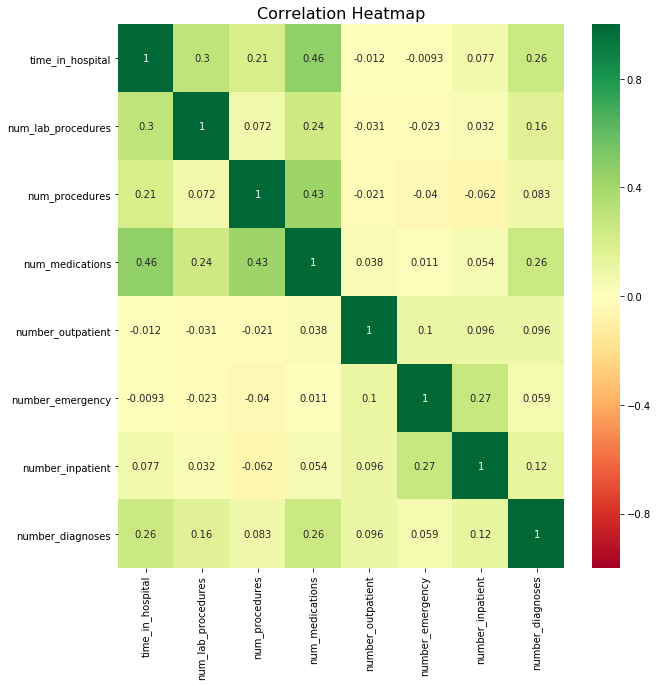

In [34]:
plt.figure(figsize=(10,10))
corr = df_cor_cols.cor().as_data_frame()
corr.index = df_cor_cols.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

#### Observations made from the heat plot above:
    * time_in_hospital has a positive correlation on num_medications, rather than number_emergency as one would suspect.
    * num_procedures has a positive correlation and significant effect on num_medications.
    * number_inpatient and number_emergency has a positive correlation. 

## Meta data

In [35]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=y
nthreads=1 
min_mem_size=6 
run_time=500
classification=True
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [36]:
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
    m_data={}
    m_data['start_time'] = time.time()
    m_data['target']=target
    m_data['server_path']=server
    m_data['data_path']=data 
    m_data['test_path']=test
    m_data['max_models']=model
    m_data['run_time']=run_time
    m_data['run_id'] =run_id
    m_data['scale']=scale
    m_data['classification']=classification
    m_data['scale']=False
    m_data['model_path']=model_path
    m_data['balance']=balance
    m_data['balance_threshold']=balance_threshold
    m_data['project'] =name
    m_data['end_time'] = time.time()
    m_data['execution_time'] = 0.0
    m_data['run_path'] =path
    m_data['nthreads'] = nthreads
    m_data['min_mem_size'] = min_mem_size
    m_data['analysis'] = analysis
    return m_data


In [37]:
def dict_to_json(dct,n):
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()

In [38]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str

In [39]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

In [40]:
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)

In [41]:
meta_data_startTime_beforeModelEval= time.asctime(time.localtime(meta_data["start_time"])) 
print("meta_data_startTime_beforeModelEval: ",meta_data_startTime_beforeModelEval)

meta_data_startTime_beforeModelEval:  Fri Apr 26 08:32:47 2019


In [42]:
meta_data_endTime_beforeModelEval= time.asctime( time.localtime(meta_data["end_time"]) )
print( "meta_data_endTime_beforeModelEval= ", meta_data_endTime_beforeModelEval)

meta_data_endTime_beforeModelEval=  Fri Apr 26 08:32:47 2019


In [43]:
# Add independent variables

meta_data['X']=predictors.columns 

In [44]:
meta_data['variables']=df.columns

In [45]:
type(predictors)
independentVars_df=predictors.as_data_frame()

In [46]:
# save the changed dataset
dataset_stats=run_id+'_independentVariables.csv'
independentVars_df.to_csv(dataset_stats, index=False)

## Train model using h2o

In [48]:
# Use Auto ML to train models
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs = run_time,project_name = name,exclude_algos=["DeepLearning","StackedEnsemble"])

In [49]:
model_start_time = time.time()

In [50]:
aml.train(x = predictors.columns, y = y, training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [51]:
meta_data['model_execution_time'] = time.time() - model_start_time

## Print Leaderboard

In [52]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190426_083250_model_1,0.703705,0.425909,0.466813,0.363647,0.132239
XRT_1_AutoML_20190426_083250,0.680463,0.438544,0.470477,0.368596,0.135863
DRF_1_AutoML_20190426_083250,0.676829,0.462069,0.466825,0.368869,0.136065
GBM_5_AutoML_20190426_083250,0.668294,0.447229,0.479222,0.37143,0.13796
GBM_1_AutoML_20190426_083250,0.662874,0.446491,0.48768,0.371619,0.138101
GBM_2_AutoML_20190426_083250,0.661852,0.447802,0.484772,0.372013,0.138394
GBM_3_AutoML_20190426_083250,0.657575,0.452341,0.486096,0.373346,0.139387
GBM_4_AutoML_20190426_083250,0.653834,0.456374,0.484323,0.374096,0.139948


In [53]:
aml.leader

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190426_083250_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1303855713609179
RMSE: 0.3610894229424588
LogLoss: 0.4197844663567225
Null degrees of freedom: 50000
Residual degrees of freedom: 48064
Null deviance: 46755.46076076399
Residual deviance: 41979.28620460497
AIC: 45853.28620460497
AUC: 0.7220592938536408
pr_auc: 0.9142439646635243
Gini: 0.4441185877072815
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4268807709608796: 


,1,0,Error,Rate
1,650.0,8224.0,0.9268,(8224.0/8874.0)
0,300.0,40827.0,0.0073,(300.0/41127.0)
Total,950.0,49051.0,0.1705,(8524.0/50001.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4268808,0.9054758,324.0
max f2,0.0982652,0.9587683,385.0
max f0point5,0.7241591,0.8703313,212.0
max accuracy,0.5191672,0.8299834,298.0
max precision,0.9698794,1.0,0.0
max recall,0.0030623,1.0,399.0
max specificity,0.9698794,1.0,0.0
max absolute_mcc,0.7874803,0.2650538,167.0
max min_per_class_accuracy,0.8343972,0.6603561,126.0
max mean_per_class_accuracy,0.8287440,0.6634372,131.0


Gains/Lift Table: Avg response rate: 82.25 %, avg score: 82.25 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100198,0.9501571,1.1987838,1.1987838,0.9860279,0.9560484,0.9860279,0.9560484,0.0120116,0.0120116,19.8783846,19.8783846
,2,0.0200196,0.9436943,1.1744345,1.1866213,0.966,0.9465289,0.9760240,0.9512934,0.0117441,0.0237557,17.4434459,18.6621315
,3,0.0300194,0.9395218,1.1720029,1.1817518,0.964,0.9415425,0.9720187,0.9480453,0.0117198,0.0354755,17.2002918,18.1751762
,4,0.0400192,0.9357561,1.1768660,1.1805309,0.968,0.9375977,0.9710145,0.9454347,0.0117684,0.0472439,17.6866000,18.0530932
,5,0.0500190,0.9325317,1.1622768,1.1768816,0.956,0.9341513,0.9680128,0.9431789,0.0116225,0.0588664,16.2276752,17.6881556
,6,0.1000180,0.9206828,1.1476875,1.1622874,0.944,0.9262505,0.9560088,0.9347164,0.0573832,0.1162497,14.7687505,16.2287449
,7,0.1500170,0.9112860,1.1335846,1.1527211,0.9324,0.9159427,0.9481402,0.9284593,0.0566781,0.1729278,13.3584565,15.2721097
,8,0.2000160,0.9026883,1.1350435,1.1483021,0.9336,0.9069187,0.9445055,0.9230747,0.0567510,0.2296788,13.5043490,14.8302137
,9,0.3000140,0.8872445,1.1114575,1.1360214,0.9142,0.8949840,0.9344044,0.9137117,0.1111435,0.3408223,11.1457539,13.6021423
,10,0.4000120,0.8714480,1.0839811,1.1230120,0.8916,0.8794706,0.9237038,0.9051519,0.1083959,0.4492183,8.3981122,12.3011998




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.13223928094364273
RMSE: 0.36364719295443865
LogLoss: 0.42590871504489036
Null degrees of freedom: 50000
Residual degrees of freedom: 48140
Null deviance: 46757.65408098023
Residual deviance: 42591.723321919126
AIC: 46313.723321919126
AUC: 0.7037050422028931
pr_auc: 0.9066396222626742
Gini: 0.4074100844057862
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.433153125379538: 


,1,0,Error,Rate
1,660.0,8214.0,0.9256,(8214.0/8874.0)
0,329.0,40798.0,0.008,(329.0/41127.0)
Total,989.0,49012.0,0.1709,(8543.0/50001.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4331531,0.9052242,325.0
max f2,0.0873276,0.9587370,386.0
max f0point5,0.7019020,0.8682434,227.0
max accuracy,0.5005779,0.8292634,306.0
max precision,0.9702211,1.0,0.0
max recall,0.0027728,1.0,399.0
max specificity,0.9702211,1.0,0.0
max absolute_mcc,0.7512555,0.2469049,198.0
max min_per_class_accuracy,0.8371292,0.6458288,124.0
max mean_per_class_accuracy,0.8352961,0.6482796,126.0


Gains/Lift Table: Avg response rate: 82.25 %, avg score: 82.25 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100198,0.9488531,1.1842237,1.1842237,0.9740519,0.9549437,0.9740519,0.9549437,0.0118657,0.0118657,18.4223718,18.4223718
,2,0.0200196,0.9426758,1.1792975,1.1817631,0.97,0.9455348,0.9720280,0.9502439,0.0117927,0.0236584,17.9297542,18.1763091
,3,0.0300194,0.9386235,1.1452560,1.1696022,0.942,0.9405851,0.9620253,0.9470265,0.0114523,0.0351108,14.5255963,16.9602155
,4,0.0400192,0.9352672,1.1598452,1.1671641,0.954,0.9369193,0.9600200,0.9445009,0.0115982,0.0467090,15.9845211,16.7164138
,5,0.0500190,0.9319813,1.1574137,1.1652148,0.952,0.9335818,0.9584166,0.9423180,0.0115739,0.0582829,15.7413670,16.5214824
,6,0.1000180,0.9200450,1.1345572,1.1498891,0.9332,0.9255969,0.9458108,0.9339591,0.0567267,0.1150096,13.4557181,14.9889068
,7,0.1500170,0.9105237,1.1262899,1.1420237,0.9264,0.9151551,0.9393414,0.9276919,0.0563134,0.1713230,12.6289941,14.2023741
,8,0.2000160,0.9022397,1.1248310,1.1377260,0.9252,0.9062752,0.9358064,0.9223383,0.0562404,0.2275634,12.4831016,13.7725990
,9,0.3000140,0.8866502,1.0971114,1.1241887,0.9024,0.8943795,0.9246717,0.9130193,0.1097090,0.3372724,9.7111445,12.4188711
,10,0.4000120,0.8712383,1.0740118,1.1116451,0.8834,0.8790767,0.9143543,0.9045341,0.1073990,0.4446714,7.4011802,11.1645111



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8296234,0.0024308,0.8308169,0.8234,0.8338,0.8308,0.8293
auc,0.7036791,0.0033407,0.7100388,0.7024939,0.6957454,0.7062833,0.7038345
err,0.1703766,0.0024308,0.1691831,0.1766,0.1662,0.1692,0.1707
err_count,1703.8,24.299795,1692.0,1766.0,1662.0,1692.0,1707.0
f0point5,0.8604329,0.0022767,0.8605765,0.8551024,0.8651286,0.8614615,0.8598955
---,---,---,---,---,---,---,---
r2,0.0944069,0.0054121,0.1026268,0.0852074,0.0851212,0.1004863,0.0985928
recall,0.9920034,0.0011943,0.9946576,0.9924205,0.9893694,0.991863,0.9917063
residual_deviance,8515.191,78.8443,8413.995,8712.95,8435.062,8451.032,8562.917
rmse,0.3635612,0.0021688,0.3611384,0.3690402,0.3611279,0.3616635,0.3648361



See the whole table with table.as_data_frame()
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2019-04-26 08:37:52,0.000 sec,2,.1E2,1937,0.9319266,nan,0.9325896,0.0051523
,2019-04-26 08:37:53,0.419 sec,4,.64E1,1937,0.9300944,nan,0.9311025,0.0051416
,2019-04-26 08:37:53,0.856 sec,6,.4E1,1937,0.9272871,nan,0.9288041,0.0051254
,2019-04-26 08:37:54,1.228 sec,8,.25E1,1937,0.9231181,nan,0.9253342,0.0051018
,2019-04-26 08:37:54,1.540 sec,10,.15E1,1937,0.9172273,nan,0.9202984,0.0050692
---,---,---,---,---,---,---,---,---,---
,2019-04-26 08:38:00,7.164 sec,40,.12E-2,1937,0.8451337,nan,0.8530041,0.0051340
,2019-04-26 08:38:00,7.624 sec,42,.75E-3,1937,0.8423780,nan,0.8522073,0.0053339
,2019-04-26 08:38:01,8.101 sec,44,.46E-3,1937,0.8395689,nan,0.8518176,0.0055642
,2019-04-26 08:38:01,8.576 sec,46,.29E-3,1937,0.8366959,nan,0.8518748,0.0058167



See the whole table with table.as_data_frame()


### Get leaderboard in data frame

In [54]:
# get leaderboard in data frame
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [55]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GLM_grid_1_AutoML_20190426_083250_model_1,0.703705,0.425909,0.466813,0.363647,0.132239
1,XRT_1_AutoML_20190426_083250,0.680463,0.438544,0.470477,0.368596,0.135863
2,DRF_1_AutoML_20190426_083250,0.676829,0.462069,0.466825,0.368869,0.136065
3,GBM_5_AutoML_20190426_083250,0.668294,0.447229,0.479222,0.371430,0.137960
4,GBM_1_AutoML_20190426_083250,0.662874,0.446491,0.487680,0.371619,0.138101
5,GBM_2_AutoML_20190426_083250,0.661852,0.447802,0.484772,0.372013,0.138394
6,GBM_3_AutoML_20190426_083250,0.657575,0.452341,0.486096,0.373346,0.139387
7,GBM_4_AutoML_20190426_083250,0.653834,0.456374,0.484323,0.374096,0.139948


In [56]:
# save all models names of the leaderboard in a csv
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats, index=False)

In [57]:
# All models. We are no longer using the best model
meta_data['models']=aml_leaderboard_df['model_id']

In [58]:
meta_data['end_time'] = time.time()

In [59]:
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']

### Variable importance based on models

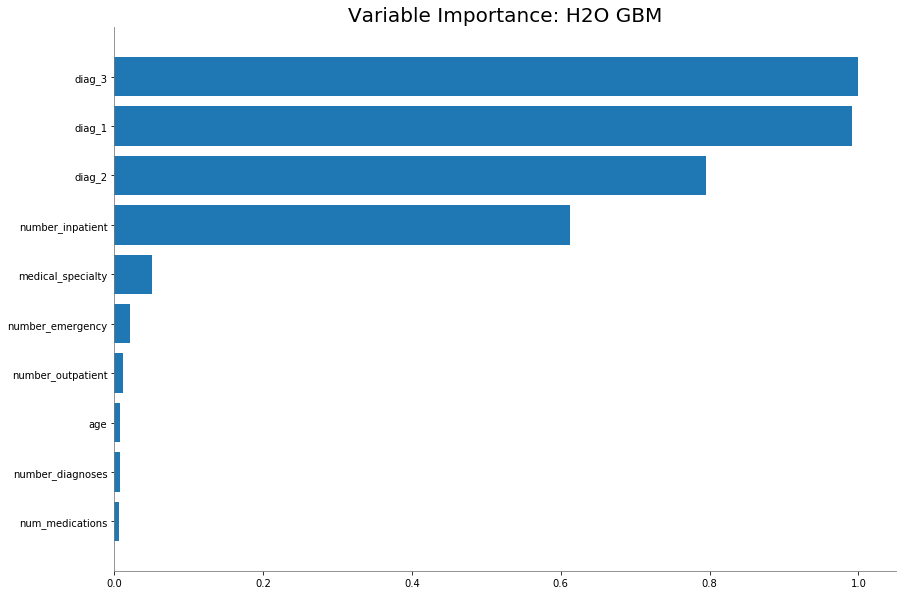

In [60]:
### Variable importance based on models

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

sample_model1=h2o.get_model(aml_leaderboard_df['model_id'][4]) 
sample_model1.varimp_plot()

#### Observations: For a GBM model with model_id "GBM_1_AutoML_20190426_083250" 
* diag_3 is an important variable for readmitted status.  Followed by diag_1, diag_2, number_inpatient, medical_specialty, number_emergency, number_outpatient, age, number_diagnoses, and num_medications.

### Convert Meta-data into JSON/ Csv Files

In [61]:
type(meta_data)

dict

In [62]:
##converting meta data into csv files

## A list of the keys of dictionary. Convert dictionary to list and then into panda Dataframe. Save the dataframe in a csv file.

list_keys = [ k for k in meta_data ]
 
## or a list of the values
list_values = [ v for v in meta_data.values() ]
 
## or just a list of the list of key value pairs
list_key_value = [ [k,v] for k, v in meta_data.items() ]

metaData_stats=run_id+'_metadata.csv'
df1 = pd.DataFrame(list_key_value)
df1.to_csv(metaData_stats)

## Find all parameters for all the models in the aml leaderboard

In [63]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GLM_grid_1_AutoML_20190426_083250_model_1,0.703705,0.425909,0.466813,0.363647,0.132239
1,XRT_1_AutoML_20190426_083250,0.680463,0.438544,0.470477,0.368596,0.135863
2,DRF_1_AutoML_20190426_083250,0.676829,0.462069,0.466825,0.368869,0.136065
3,GBM_5_AutoML_20190426_083250,0.668294,0.447229,0.479222,0.371430,0.137960
4,GBM_1_AutoML_20190426_083250,0.662874,0.446491,0.487680,0.371619,0.138101
5,GBM_2_AutoML_20190426_083250,0.661852,0.447802,0.484772,0.372013,0.138394
6,GBM_3_AutoML_20190426_083250,0.657575,0.452341,0.486096,0.373346,0.139387
7,GBM_4_AutoML_20190426_083250,0.653834,0.456374,0.484323,0.374096,0.139948


In [64]:
# How to access the first model name in the data frame w/o index

print("First Model: ", aml_leaderboard_df['model_id'][0])  

First Model:  GLM_grid_1_AutoML_20190426_083250_model_1


In [65]:
#declaring a dictionary to hold all the parameters for all the models predicted by the aml leaderboard
leaderboard_params={}
type(leaderboard_params)

dict

### Saving all parameters from all models in a JSON file/ CSV file.

In [67]:
## for loop is used to store the model_id and it's corresponding parameters in a dictionary.
   ## Stores on the parameters. Not the hyper parameters. For all models in the leaderboard.
    ## Generating JSON files and CSV files.


for i in range(0, len(aml_leaderboard_df)):
    modelName= aml_leaderboard_df['model_id'][i]
    testModel=h2o.get_model(modelName)
    v_file=testModel.params
    n=run_id+'_'+testModel.model_id+'_nonhy_parameter.json'
    dict_to_json(v_file,n)
    #testModelCSV=v_file
    ##converting meta data into csv files
    #list_keys = [ k for k in testModelCSV ]
    ## or a list of the values
    #list_values = [ v for v in testModelCSV.values() ]
    ## or just a list of the list of key value pairs
    #list_key_value = [ [k,v] for k, v in testModelCSV.items() ]
    #metaData_stats=run_id+'_'+testModel.model_id+'_nonhy_parameter.csv'
    #df1 = pd.DataFrame(list_key_value)
    #df1.to_csv(metaData_stats)

In [68]:
## Plot Learning curve for parameters
gbm1= h2o.get_model(aml_leaderboard_df['model_id'][4])

In [69]:
type(gbm1)

h2o.estimators.gbm.H2OGradientBoostingEstimator

In [70]:
gbmLogloss=gbm1.logloss()
gbmLogloss

0.3177818328270531

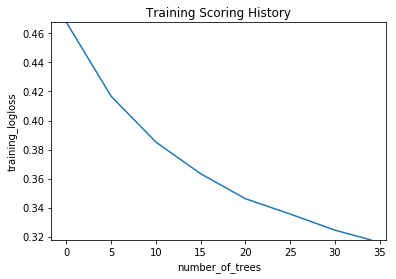

In [71]:
gbm1.plot()

#### Observation:
With an increase in number of trees, log loss is decreasing. Hence, the accuracy is better when number of trees is less. 

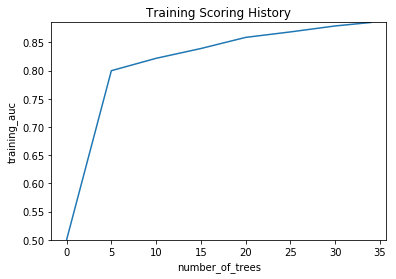

In [72]:
gbm1.plot(metric='auc')

#### Observation:
With an increase in number of trees, log loss is decreasing. Hence, the accuracy is better when number of trees is less. 

## Find the best Hyperparameters

Hyperparameters for GBM are as follows:

* n-trees : Build more trees so as to increase the validation set error
* learn_rate: Ideally, should be less. Make learn_rate= 0.02. 
* learn_rate_annealing: Reduce learning rate with addition of each tree. Make learn_rate_annealing=0.995.
    * To make it faster, make learn rate=0.05 and learn_rate_annealing=0.99
* max_depth: Deeper  trees takes longer to train. Keep this less than 10.
* sample_rate: Row sampling. Ideally, sample (70-80 percent of the data), ie, 0.7-0.8
* col_sample_rate: Column sampling.

Hyperparameters for Random Forest is as follows:
* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

Hyperparameters for GLM is as follows:
* tweedie_variance_power = When family=tweedie, this option can be used to specify the power for the tweedie variance. This option defaults to 0.
The Tweedie distribution is parametrized by variance power p. It is defined for all p values except in the (0,1) interval and has the following distributions as special cases:
<br/>
p=0: Normal<br/>
p=1: Poisson<br/>
p∈(1,2): Compound Poisson, non-negative with mass at zero<br/>
p=2: Gamma<br/>
p=3: Gaussian<br/>
p>2: Stable, with support on the positive reals
<br/>
* tweedie_link_power = Tweedie distributions are a family of distributions that include gamma, normal, Poisson and their combinations. This distribution is especially useful for modeling positive continuous variables with exact zeros. When family=tweedie, the tweedie_link_power option can be used to specify the power for the tweedie link function.
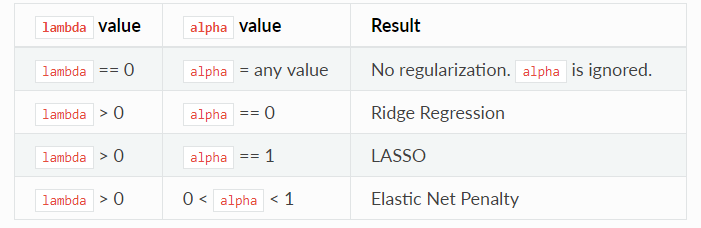
* alpha and lambda = To get the best possible model, GLM needs to find the optimal values of the regularization parameters α and λ. When performing regularization, penalties are introduced to the model buidling process to avoid overfitting, to reduce variance of the prediction error, and to handle correlated predictors. 
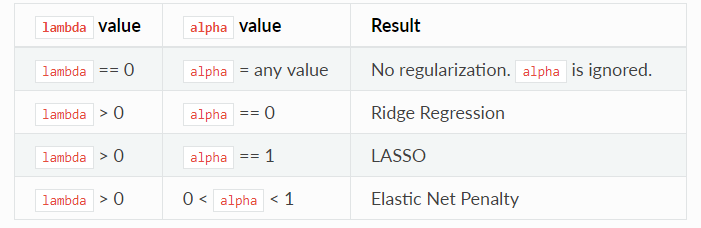
* standarize: This option specifies whether to standardizes numeric columns to have zero mean and unit variance. Enabling this option produces standardized coefficient magnitudes in the model output.
* missing_values_handling: This option is used to specify the way that the algorithm will treat missing values. <br/>
If you have few columns with many NAs, you might accidentally be losing all your rows, so its better to exclude (skip) them.
<br/>
If you have many columns with a small fraction of uniformly distributed missing values, every row will likely have at least one missing value. In this case, impute the NAs (e.g., substitute the NAs with mean values) before modeling.
* max_iterations= This option specifies the maximum allowed number of iterations (passes over data) during model training. the default is 50 if no lambda search; 10* number of lambdas otherwise
* balance_classes= The balance_classes option can be used to balance the class distribution. When enabled, H2O will either undersample the majority classes or oversample the minority classes. Note that the resulting model will also correct the final probabilities (“undo the sampling”) using a monotonic transform, so the predicted probabilities of the first model will differ from a second model. However, because AUC only cares about ordering, it won’t be affected.
* class_sampling_factors= By default, sampling factors will be automatically computed to obtain class balance during training. You can change this behavior using the class_sampling_factors option. This option sets an over/under-sampling ratio for each class (in lexicographic order). Note that this requires balance_classes=true.
* max_after_balance_size= To reduce the data frame size, you can use the max_after_balance_size option. 
* max_runtime_secs= When building a model, this option specifes the maximum runtime in seconds that you want to allot in order to complete the model. If this maximum runtime is exceeded before the model build is completed, then the model will fail.
<br/>
Specifying max_runtime_secs=0 disables this option, thus allowing for an unlimited amount of runtime.

#### We try to check the plot between hyperparameter against its values to know the best value range. This was done with the help of database team.

## Last step

In [76]:
# in case of server error, run this.
h2o.cluster().shutdown()

# Citations
* https://www.hindawi.com/journals/bmri/2014/781670/
* https://www.kaggle.com/sudalairajkumar/getting-started-with-h2o
* https://www.pythonforbeginners.com/dictionary/how-to-use-dictionaries-in-python/
* https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb
* http://h2o-release.s3.amazonaws.com/h2o/master/3233/docs-website/h2o-py/docs/h2o.model.html
* https://github.com/nikbearbrown/CSYE_7245/tree/master/H2O
* https://github.com/prabhuSub/Hyperparamter-Samples

# Contributions
By own: 45%
External resource: 55%

# Team Members:
Team Name: DS01
 * Michelle Pradeep
     * NUID: 001422140
     * E-mail ID: pradeep.m@husky.neu.edu
 * Seemanthini Jois
      * NUID: 001439942
      * E-mail ID: jois.s@husky.neu.edu
 * Suraksha Jadhav
      * NUID: 001430368
      * E-mail ID: jadhav.su@husky.neu.edu

# The MIT License


Copyright (c)  2019 Michelle Pradeep, Seemanthini Jois, Suraksha Jadhav.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.